In [1]:
# import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import linregress

In [3]:
# Import Data (Smaller test data to start with)
file_path = './air_pollution_tidy.csv'
raw_data = pd.read_csv(file_path)

In [4]:
# DataFrame info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1722057 entries, 0 to 1722056
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   State              object 
 1   Date Local         object 
 2   NO2 Mean           float64
 3   NO2 1st Max Value  float64
 4   O3 Mean            float64
 5   O3 1st Max Value   float64
 6   SO2 Mean           float64
 7   SO2 1st Max Value  float64
 8   CO Mean            float64
 9   CO 1st Max Value   float64
 10  year               int64  
dtypes: float64(8), int64(1), object(2)
memory usage: 144.5+ MB


In [5]:
# Data cleaning (any zeros or NaN)
col_list = ['State', 'Date Local', 'NO2 Mean', 'NO2 1st Max Value', 'O3 Mean', 'O3 1st Max Value', 'SO2 Mean', 'SO2 1st Max Value', 'CO Mean',  'CO 1st Max Value']

trim_data = raw_data[col_list]

# Find any NaN
for col in col_list:
    print(col)
    display(trim_data.loc[trim_data[col].isna()])
    
# Drop Country of Mexico
trim_data = trim_data.loc[trim_data['State'] != 'Country Of Mexico']


State


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


Date Local


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


NO2 Mean


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


NO2 1st Max Value


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


O3 Mean


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


O3 1st Max Value


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


SO2 Mean


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


SO2 1st Max Value


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


CO Mean


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


CO 1st Max Value


,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value


In [6]:
# Create Tidy Dataset 
tidy_data = trim_data.copy()

# Add Year Column
tidy_data['year'] = tidy_data['Date Local'].str[:4]

# Drop 2016 Data due to partial year
tidy_data = tidy_data.loc[tidy_data['year'] != '2016']

# Save Tidy Data
# tidy_data.to_csv('air_pollution_tidy.csv', index = False)


In [2]:
# Read it back in
tidy_data = pd.read_csv('air_pollution_tidy.csv')
tidy_data.tail()

,State,Date Local,NO2 Mean,NO2 1st Max Value,O3 Mean,O3 1st Max Value,SO2 Mean,SO2 1st Max Value,CO Mean,CO 1st Max Value,year
1722052,Wyoming,2015-12-30,7.047826,18.8,0.036917,0.043,-0.057143,0.2,0.154167,0.200,2015
1722053,Wyoming,2015-12-31,2.445833,8.8,0.038263,0.040,-0.187500,-0.1,0.103458,0.155,2015
1722054,Wyoming,2015-12-31,2.445833,8.8,0.038263,0.040,-0.187500,-0.1,0.100000,0.100,2015
1722055,Wyoming,2015-12-31,2.445833,8.8,0.038263,0.040,-0.175000,-0.1,0.103458,0.155,2015
1722056,Wyoming,2015-12-31,2.445833,8.8,0.038263,0.040,-0.175000,-0.1,0.100000,0.100,2015


In [3]:
# Narrow Down to NO2
data_no2 = tidy_data[['State', 'Date Local', 'year', 'NO2 Mean', 'NO2 1st Max Value']].copy()

data_no2.head()

,State,Date Local,year,NO2 Mean,NO2 1st Max Value
0,Arizona,2000-01-01,2000,19.041667,49.0
1,Arizona,2000-01-01,2000,19.041667,49.0
2,Arizona,2000-01-01,2000,19.041667,49.0
3,Arizona,2000-01-01,2000,19.041667,49.0
4,Arizona,2000-01-02,2000,22.958333,36.0


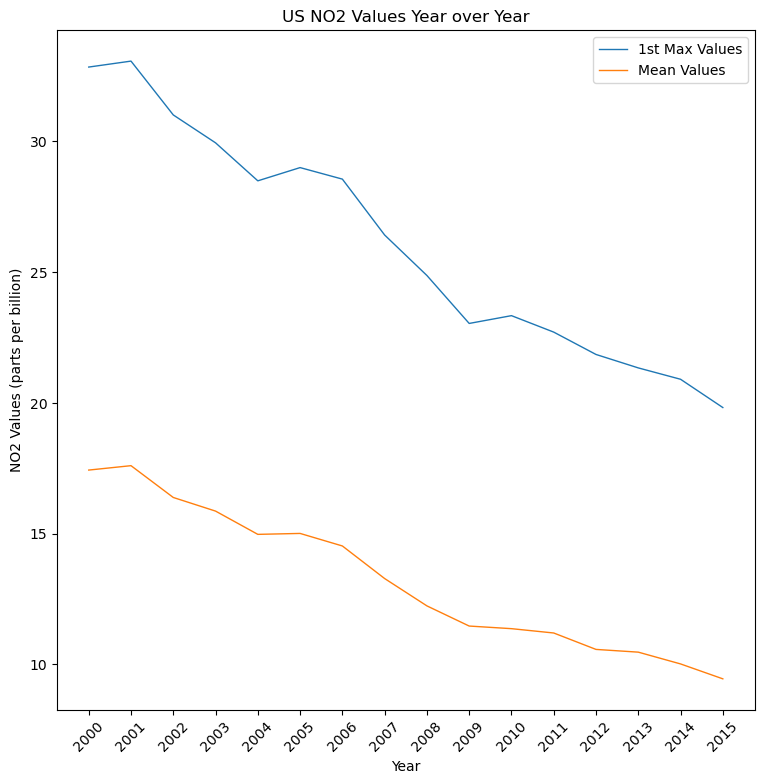

The r-squared is: 0.972974892694339
The p-value is 2.2320165006092868e-12


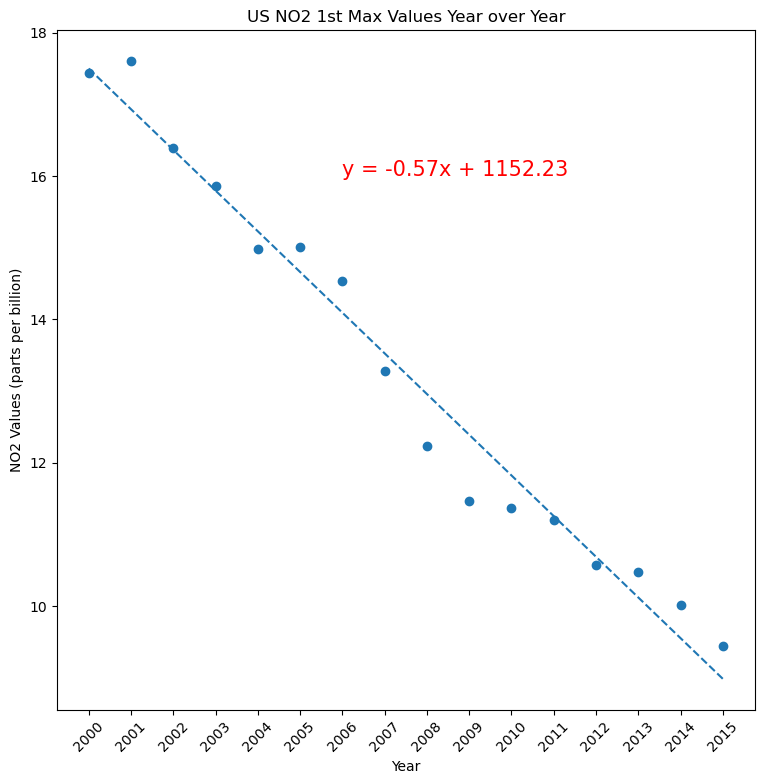

In [24]:
# Year-over-year

# Group data by years
group = data_no2.groupby('year')
mean = group.mean()

# Use .arange to make x values for the following charts/graphs
x_values = np.arange(2000, 2016, 1)
x_values

y_values = group['NO2 1st Max Value'].mean()
y_values_mean = group['NO2 Mean'].mean()

plt.figure(figsize = (9, 9), dpi = 100)

# Line graph for US NO2 1st Max Values and NO2 Mean Values
plt.plot(x_values, y_values, linewidth = 1, label = '1st Max Values')
plt.plot(x_values, y_values_mean, linewidth = 1, label = 'Mean Values')
plt.title('US NO2 Values Year over Year')
plt.xlabel('Year')
plt.ylabel('NO2 Values (parts per billion)')
plt.legend(loc = 'best')
plt.savefig('./us_no2_plot.png')
plt.xticks(ticks = x_values, rotation = 45)
plt.show()

plt.figure(figsize = (9, 9), dpi = 100)

# Linear regression analysis for US NO2 1st Max Values
plt.scatter(x_values, y_values_mean)

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values_mean)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values, regress_values, "--")
plt.annotate(line_eq, (2006, 16), fontsize = 15, color = "red")

plt.title('US NO2 Mean Values Year over Year')
plt.xlabel('Year')
plt.ylabel('NO2 Values (parts per billion)')
print(f"The r-squared is: {rvalue**2}")
print(f'The p-value is {pvalue}')
plt.savefig('./us_no2_plot_linregress.png')
plt.xticks(ticks = x_values, rotation = 45)
plt.show()

In [5]:
# Regional
# Regional differences
region_dict = {
    'Alabama':'South',
    'Alaska':'West',
    'Arizona':'West',
    'Arkansas':'South',
    'California':'West',
    'Colorado':'West',
    'Connecticut':'Northeast',
    'Delaware':'Northeast',
    'District Of Columbia' : 'Northeast',
    'Florida':'South',
    'Georgia':'South',
    'Hawaii':'West',
    'Idaho':'West',
    'Illinois':'Midwest',
    'Indiana':'Midwest',
    'Iowa':'Midwest',
    'Kansas':'Midwest',
    'Kentucky':'South',
    'Louisiana':'South',
    'Maine':'Northeast',
    'Maryland':'South',
    'Massachusetts':'Northeast',
    'Michigan':'Midwest',
    'Minnesota':'Midwest',
    'Mississippi':'South',
    'Missouri':'Midwest',
    'Montana':'West',
    'Nebraska':'Midwest',
    'Nevada':'West',
    'New Hampshire':'Northeast',
    'New Jersey':'Northeast',
    'New Mexico':'West',
    'New York':'Northeast',
    'North Carolina':'South',
    'North Dakota':'Midwest',
    'Ohio':'Midwest',
    'Oklahoma':'South',
    'Oregon':'West',
    'Pennsylvania':'Northeast',
    'Rhode Island':'Northeast',
    'South Carolina':'South',
    'South Dakota':'Midwest',
    'Tennessee':'South',
    'Texas':'South',
    'Utah':'West',
    'Vermont':'Northeast',
    'Virginia':'South',
    'Washington':'West',
    'West Virginia':'South',
    'Wisconsin':'Midwest',
    'Wyoming':'West',
}


In [6]:
# Map Region into the dataframe
data_no2['Region'] = data_no2['State'].map(region_dict)

data_no2.head()

,State,Date Local,year,NO2 Mean,NO2 1st Max Value,Region
0,Arizona,2000-01-01,2000,19.041667,49.0,West
1,Arizona,2000-01-01,2000,19.041667,49.0,West
2,Arizona,2000-01-01,2000,19.041667,49.0,West
3,Arizona,2000-01-01,2000,19.041667,49.0,West
4,Arizona,2000-01-02,2000,22.958333,36.0,West


In [7]:
# Create a DataFrame group by region and then year

grouped_region_yr = data_no2.groupby(['Region', 'year']).mean()

grouped_region_yr = grouped_region_yr.reset_index(drop = False)

grouped_region_yr.head()

# grouped_region_yr.to_clipboard(sep = ',')

,Region,year,NO2 Mean,NO2 1st Max Value
0,Midwest,2000,17.589403,33.140399
1,Midwest,2001,17.011671,32.445508
2,Midwest,2002,15.402753,30.286323
3,Midwest,2003,15.678108,30.333333
4,Midwest,2004,14.031407,27.767409


In [8]:
# Visualization
northeast = grouped_region_yr.loc[grouped_region_yr['Region'] == 'Northeast'].copy()
midwest = grouped_region_yr.loc[grouped_region_yr['Region'] == 'Midwest'].copy()
south = grouped_region_yr.loc[grouped_region_yr['Region'] == 'South'].copy()
west = grouped_region_yr.loc[grouped_region_yr['Region'] == 'West'].copy()

# west.plot(kind = 'line', x = 'year', y = 'NO2 Mean')
# northeast.plot(kind = 'line', x = 'year', y = 'NO2 Mean', color = 'darkorange')

# plt.show()

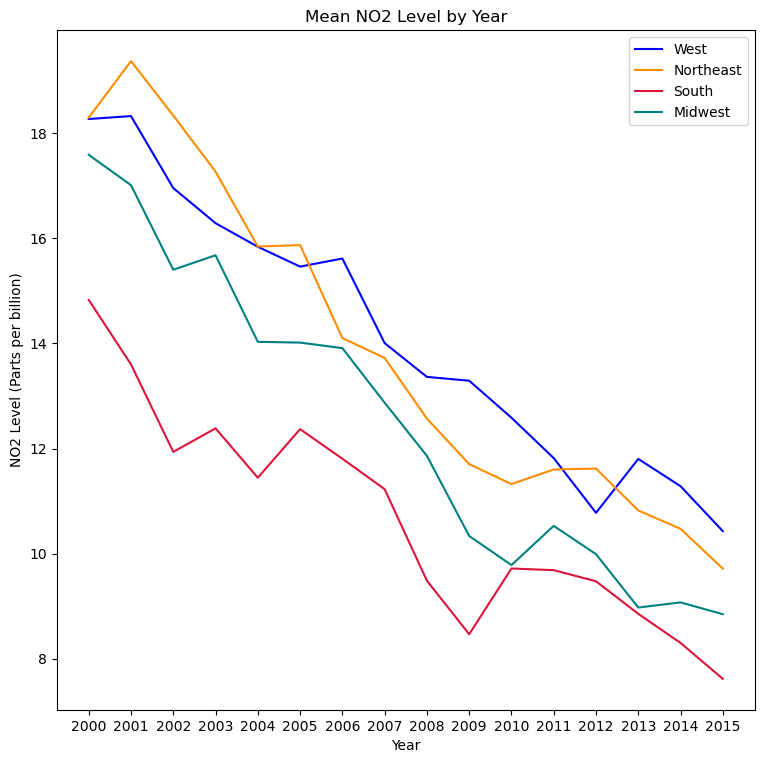

In [9]:
plt.figure(figsize = (9, 9), dpi = 100)

x = west['year']
y = west['NO2 Mean']

plt.plot(x, y, color = 'b', label = 'West')

x1 = northeast['year']
y1 = northeast['NO2 Mean']

plt.plot(x1, y1, color = 'darkorange', label = 'Northeast')

x2 = south['year']
y2 = south['NO2 Mean']

plt.plot(x2, y2, color = 'crimson', label = 'South')

x3 = midwest['year']
y3 = midwest['NO2 Mean']

plt.plot(x3, y3, color = 'teal', label = 'Midwest')

plt.title('Mean NO2 Level by Year')
plt.xlabel('Year')
plt.ylabel('NO2 Level (Parts per billion)')
plt.xticks(ticks = x)

plt.legend();

In [57]:
# let's try monthly

data_no2['month'] = data_no2['Date Local'].str[5:7]

data_no2['yearmonth'] = data_no2['year'].astype(str) + data_no2['month'].astype(str)

data_no2.head()

,State,Date Local,year,NO2 Mean,NO2 1st Max Value,Region,month,yearmonth
0,Arizona,2000-01-01,2000,19.041667,49.0,West,01,200001
1,Arizona,2000-01-01,2000,19.041667,49.0,West,01,200001
2,Arizona,2000-01-01,2000,19.041667,49.0,West,01,200001
3,Arizona,2000-01-01,2000,19.041667,49.0,West,01,200001
4,Arizona,2000-01-02,2000,22.958333,36.0,West,01,200001


In [64]:
# groupby region, year, month

gby_region_yrmo = data_no2.groupby(['Region', 'yearmonth']).mean()

gby_region_yrmo = gby_region_yrmo.reset_index( drop = False)

In [61]:
gby_region_yrmo.to_clipboard(sep = ',')

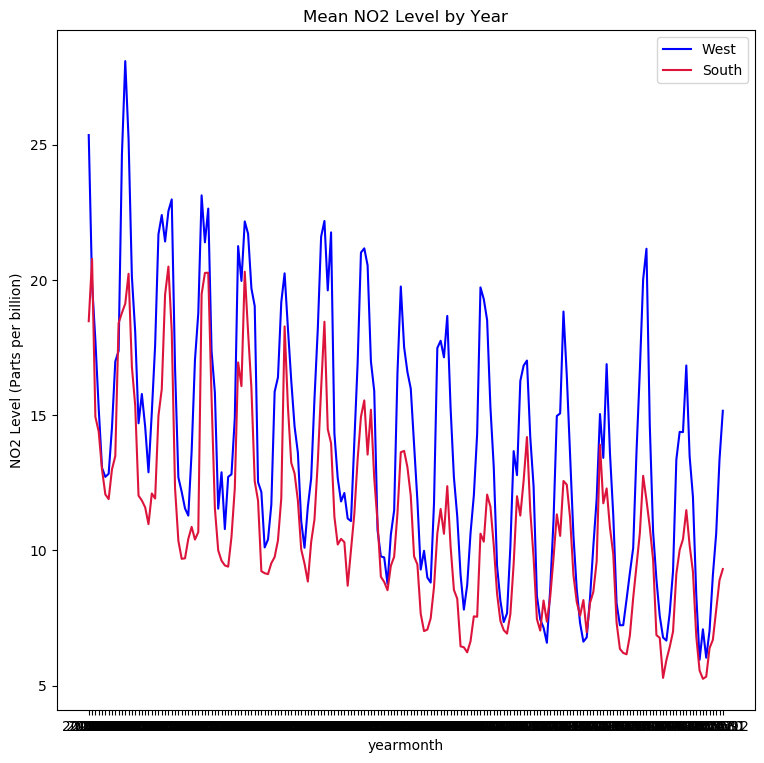

In [68]:
northeast = gby_region_yrmo.loc[gby_region_yrmo['Region'] == 'Northeast'].copy()
midwest = gby_region_yrmo.loc[gby_region_yrmo['Region'] == 'Midwest'].copy()
south = gby_region_yrmo.loc[gby_region_yrmo['Region'] == 'South'].copy()
west = gby_region_yrmo.loc[gby_region_yrmo['Region'] == 'West'].copy()

# west.plot(kind = 'line', x = 'year', y = 'NO2 Mean')
# northeast.plot(kind = 'line', x = 'year', y = 'NO2 Mean', color = 'darkorange')

plt.figure(figsize = (9, 9), dpi = 100)

x = west['yearmonth']
y = west['NO2 Mean']

plt.plot(x, y, color = 'b', label = 'West')

# x1 = northeast['yearmonth']
# y1 = northeast['NO2 Mean']

# plt.plot(x1, y1, color = 'darkorange', label = 'Northeast')

x2 = south['yearmonth']
y2 = south['NO2 Mean']

plt.plot(x2, y2, color = 'crimson', label = 'South')

# x3 = midwest['yearmonth']
# y3 = midwest['NO2 Mean']

# plt.plot(x3, y3, color = 'teal', label = 'Midwest')

plt.title('Mean NO2 Level by Month')
plt.xlabel('yearmonth')
plt.ylabel('NO2 Level (Parts per billion)')
plt.xticks(ticks = x)

plt.legend();
plt.show()